In [1]:
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy.ndimage.interpolation import shift

import nbimporter
from lib import *

import gym
import gym_env
from stable_baselines3 import TD3, A2C, DDPG, SAC, PPO, DQN, HerReplayBuffer
from stable_baselines3.common.env_checker import check_env

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

In [2]:
algorithms = {
    "td3" : TD3,
    "a2c" : A2C,
    "ddpg" : DDPG,
    "sac" : SAC,
    "ppo" : PPO,
    "dqn" : DQN
}

In [3]:
df = pd.read_csv('../../data/thm/processed_thermal_data.csv')
#df = pd.read_csv('../../data/eps/processed_test_power_measurements_2.csv')
print(len(df))

"""# Creating Sigmoid
increase = 200
increase_gradient = 100
x = np.linspace(-increase_gradient, increase_gradient, len(df))
sigmoid = 1/(1 + np.exp(-x-20))*increase
df["B1_sigmoid"] = df["B1_temp"] + sigmoid"""

111232


'# Creating Sigmoid\nincrease = 200\nincrease_gradient = 100\nx = np.linspace(-increase_gradient, increase_gradient, len(df))\nsigmoid = 1/(1 + np.exp(-x-20))*increase\ndf["B1_sigmoid"] = df["B1_temp"] + sigmoid'

In [4]:
columns = ["B1_temp"]
columns_anomalies = ["B1_temp"]

df = find_anomalies(df, columns_anomalies)
data_pre = df[columns].values
data = data_pre.reshape((data_pre.shape[0],))
#noise = np.random.normal(0,5,110000)
#data_noisy = data + noise

In [15]:
episode_length = 100
obs_size = 1
predict_iter = 100000

df_tmp = df.iloc[:predict_iter]

algorithm_name = "ddpg"
algorithm = algorithms[algorithm_name]
normalizer = Normalizer(data)

In [16]:
test_list = []
for j in range(1,5):
    env = gym.make("Anomaly-v4", data=data, episode_length=episode_length, obs_size=obs_size)
    obs = env.reset(force=True)
    model = algorithm.load(f'tmp/best_models/{algorithm_name}_models/{columns[0]}/OBS_{obs_size}/EL_{episode_length}/model_{j}', env=env)
    env.reset(force=True)
    actions = np.zeros(predict_iter)
    observations = np.zeros(predict_iter)
    rewards = np.zeros(predict_iter)
    for i in range(predict_iter):
        action, _states = model.predict(obs)
        actions[i] = action
        obs, reward, done, info = env.step(action)
        observations[i] = obs[-1]
        rewards[i] = reward
        if done:
            obs = env.reset()
    env.close()

    predicted = normalizer.denormalize(actions)
    df_tmp[f"Test_{j}"] = predicted
    test_list.append(f"Test_{j}")
    #values = normalizer.denormalize(observations)   
    #directory_path = setup_directory(main_path)
    #save_info(directory_path, episode_length, lookback, train_timesteps, predict_iter, columns)


<ipython-input-16-380490faf36e>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp[f"Test_{j}"] = predicted


In [17]:
df_tmp['Mean'] = df_tmp[test_list].mean(axis = 1)
df_tmp["STD"] = df_tmp[test_list].std(axis = 1)
df_tmp['Variance'] = df_tmp["STD"]**2
df_tmp["Upper_boundary"] = df_tmp['Mean'] + df_tmp["STD"]
df_tmp["Lower_boundary"] = df_tmp['Mean'] - df_tmp["STD"]
#df_tmp["Anomalies"] = ((df_tmp["B1_temp"] >df_tmp["Upper_boundary"]) | (df_tmp["B1_temp"] <df_tmp["Lower_boundary"]))

<ipython-input-17-40bc446f042b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['Mean'] = df_tmp[test_list].mean(axis = 1)
<ipython-input-17-40bc446f042b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["STD"] = df_tmp[test_list].std(axis = 1)
<ipython-input-17-40bc446f042b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [18]:
df_plot = df_tmp.iloc[:,:]

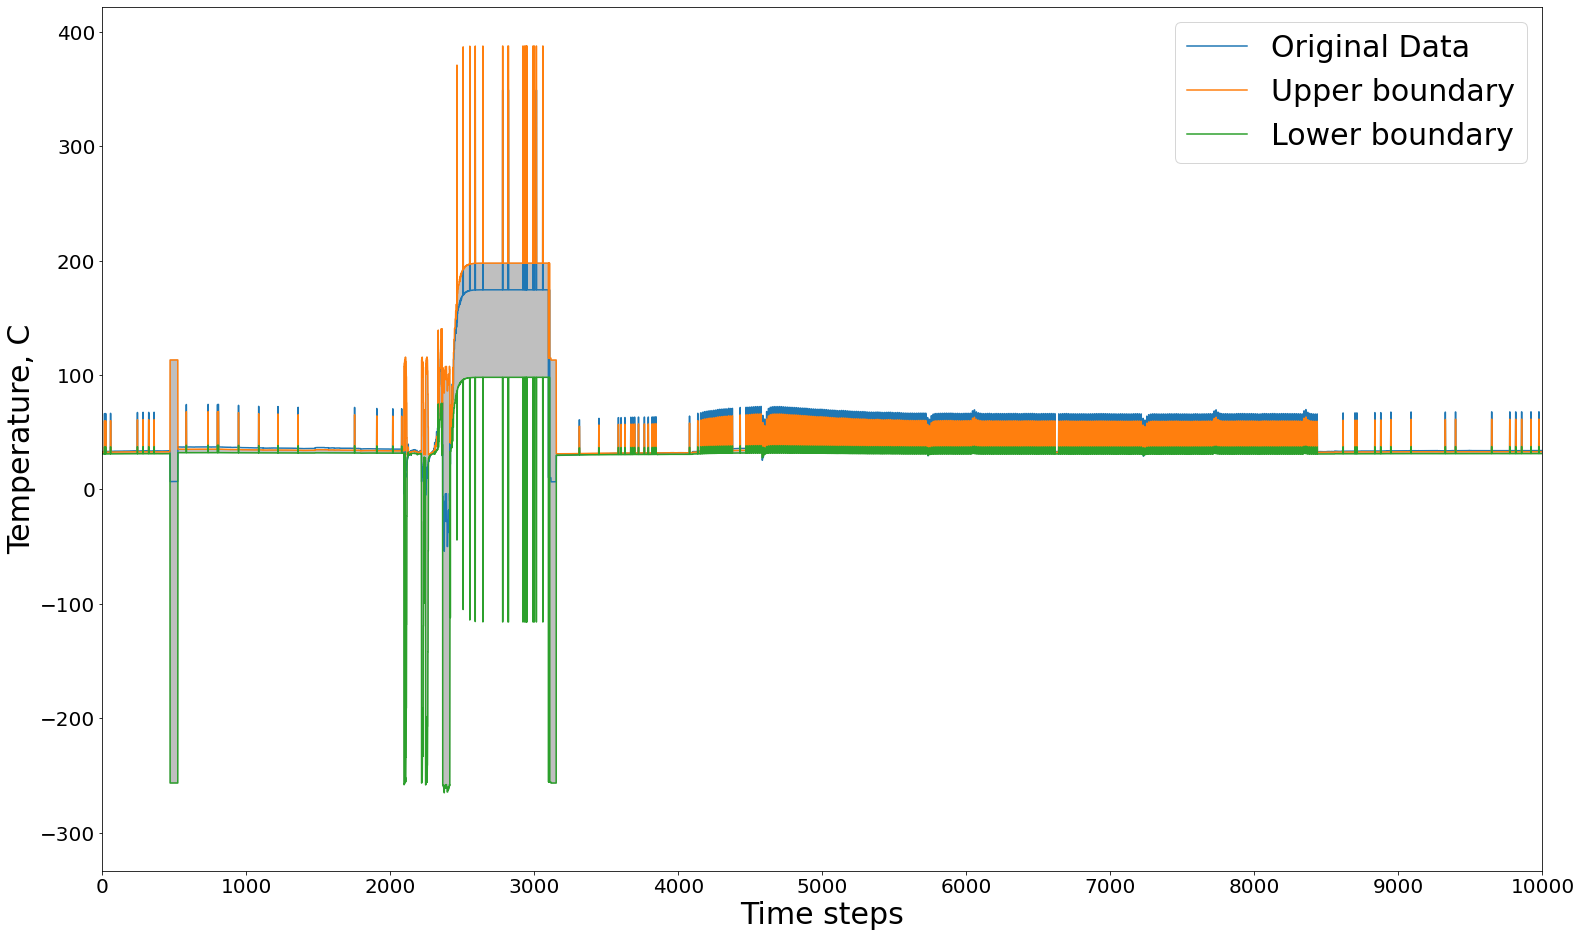

In [19]:
fig = plt.figure(figsize =(25, 15))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
max_xticks = 10
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)
ax.plot(df_plot.index, df_plot['B1_temp'], label="Original Data")
ax.plot(df_plot.index, df_plot["Upper_boundary"], label="Upper boundary")
ax.plot(df_plot.index, df_plot["Lower_boundary"], label="Lower boundary")
ax.fill_between(df_plot.index, df_plot["Upper_boundary"], df_plot["Lower_boundary"], color='grey', alpha=0.5)
#ax.plot(df_plot["Anomalies"].index, df_plot["B1_temp"][df_plot["Anomalies"].index], marker = 'o', ms = 3, mec = 'r', mfc = 'r', linestyle = "None", label="Anomalies")
ax.set_xlabel('Time steps', fontsize=30)
ax.set_ylabel('Temperature, C', fontsize=30)
ax.set_xlim(0, 10000)
ax.legend(fontsize=30)
#fig.savefig(full_path, facecolor='white', transparent=False)
plt.show()
plt.close(fig)

In [20]:
#test_name = f"{algorithm_name}_certainty_{''.join(columns)}_close"
#file_path = f"/Users/mykytaprokayev/Documents/TUM/Master Thesis/latex/images/{test_name}.svg"
#fig.savefig(file_path, facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')
#plt.close(fig)   
#command = f"/Applications/Inkscape.app/Contents/MacOS/inkscape -D /Users/mykytaprokayev/Documents/TUM/Master\ Thesis/latex/images/{test_name}.svg  -o /Users/mykytaprokayev/Documents/TUM/Master\ Thesis/latex/images/{test_name}.pdf --export-latex"
#os.system(command)

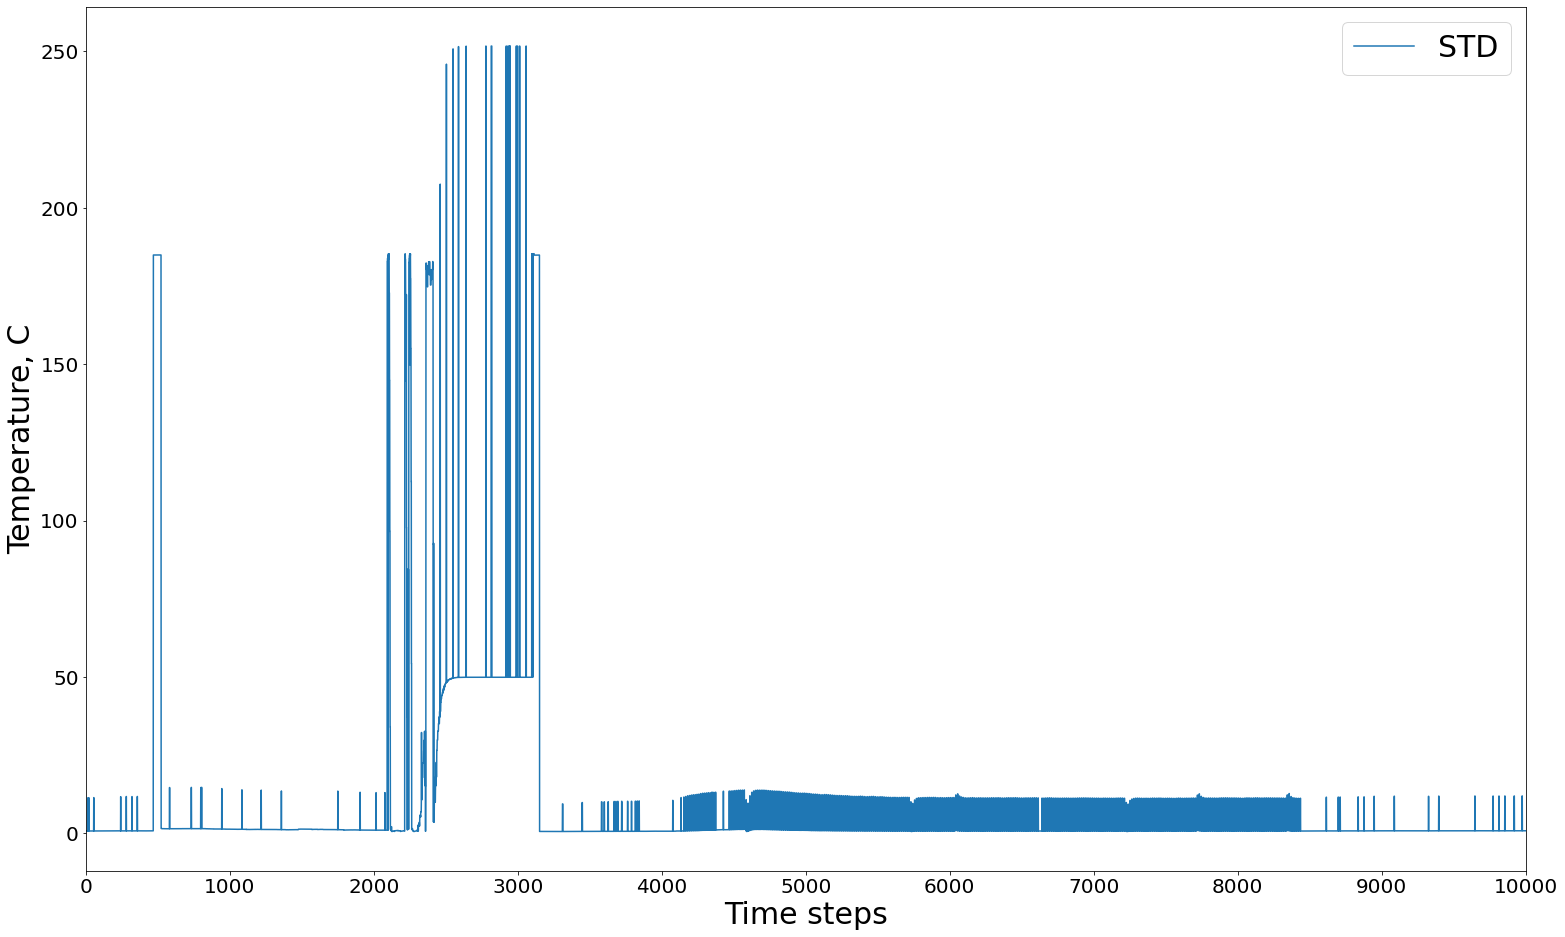

In [23]:
fig = plt.figure(figsize =(25, 15))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
max_xticks = 10
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)
ax.plot(df_plot.index, df_plot['STD'], label="STD")
#ax.plot(df_plot["Anomalies"].index, df_plot["STD"][df_plot["Anomalies"].index], marker = 'o', ms = 3, mec = 'r', mfc = 'r', linestyle = "None", label="Anomalies")
ax.set_xlabel('Time steps', fontsize=30)
ax.set_ylabel('Temperature, C', fontsize=30)
ax.set_xlim(0, 10000)
ax.legend(fontsize=30)
#fig.savefig(full_path, facecolor='white', transparent=False)
plt.show()

In [24]:
test_name = f"{algorithm_name}_certainty_{''.join(columns)}_std"
file_path = f"/Users/mykytaprokayev/Documents/TUM/Master Thesis/Presentation_images/{test_name}.png"
fig.savefig(file_path, facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')
plt.close(fig)   
#command = f"/Applications/Inkscape.app/Contents/MacOS/inkscape -D /Users/mykytaprokayev/Documents/TUM/Master\ Thesis/latex/images/{test_name}.svg  -o /Users/mykytaprokayev/Documents/TUM/Master\ Thesis/latex/images/{test_name}.pdf --export-latex"
#os.system(command)